Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [ ]:
# !pip install scipy==1.6.0

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle
import seaborn as sns
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"


category = "real_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [3]:
clrs = ['#C0392B', "#F1948A", "#D7BDE2", "#8E44AD", "#7FB3D5", "#2874A6", "#76D7C4", "#117A65",
        "#A9DFBF", "#F1C40F", "#EB984E", "#839192", "#566573"
       ]
len(clrs)

13

In [4]:
ordered_methods = [
    'constrastive+KM',
    'constrastive+LD',
    'scziDesk',
    'scDeepCluster',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scrna',
    'soup',
    'simlr',
    'raceid',
    'cidr',
    'pca_kmeans',
]

# Real Data

In [5]:
all_data = all_data[~all_data["dataset"].str.contains("2100")]

In [6]:
datasets = all_data["dataset"].unique()
datasets

array(['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm',
       'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam',
       'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung',
       'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell',
       'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC'],
      dtype=object)

In [7]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm\nNeuron\nCell',
    'mouse_bladder_cell': 'Mouse\nBladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS\nTrachea',
    'Quake_Smart-seq2_Diaphragm': 'QS\nDiaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb\nMuscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb\nMuscle',
}

all_data["dataset_label"] = all_data["dataset"].apply(
    lambda x: dataset_names.get(x, x))

datasets = [
    'Quake_10x_Limb_Muscle', 'Quake_Smart-seq2_Diaphragm',
    'Quake_Smart-seq2_Trachea', 'Quake_10x_Spleen', 'Muraro',
    'Quake_Smart-seq2_Lung', 'Young'
]

# ARI score plot

In [26]:
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]
rankKM

rank = pd.concat([rankKM, rankLD], axis = 1)

rank["rank"] = rank.apply(lambda x: min(x.values), axis = 1)

rank = rank["rank"] 

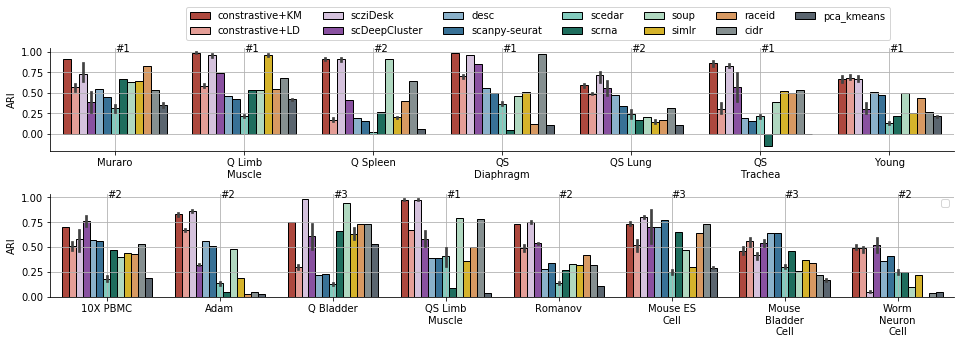

In [43]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(211)

sns.barplot(x="dataset_label",
            y="ARI",
            hue="method",
            data=all_data[all_data["dataset"].isin(datasets)].sort_values(
                by=["order", "dataset"]),
            palette=clrs,
            edgecolor='black',
            linewidth=1,
            ax=ax)
plt.grid()
plt.legend(bbox_to_anchor=(0.15, 1.4), loc=2, borderaxespad=0., ncol=7)
plt.xlabel("")
sns.despine()
# Ranking
seld = all_data[all_data["dataset"].isin(datasets)].sort_values(
    by=["order", "dataset"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i, 1, f"#{int(rank[d])}")

ax = plt.subplot(212)
sns.barplot(x = "dataset_label", y="ARI", hue = "method",
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by=["order", "dataset"]),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.grid()
plt.legend([])
# Ranking
seld = all_data[~all_data["dataset"].isin(datasets)].sort_values(
    by=["order", "dataset"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i, 1, f"#{int(rank[d])}")
sns.despine()
plt.xlabel("")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_ARI_barplot.pdf", bbox_inches='tight')

In [10]:
method_color = dict(zip(ordered_methods, clrs))

sel_methods = ['constrastive+KM', 'scziDesk',  'scDeepCluster','desc','scanpy-seurat']
sel_clrs = [method_color[m] for m in sel_methods]

# NMI, Silhouette, Calinski

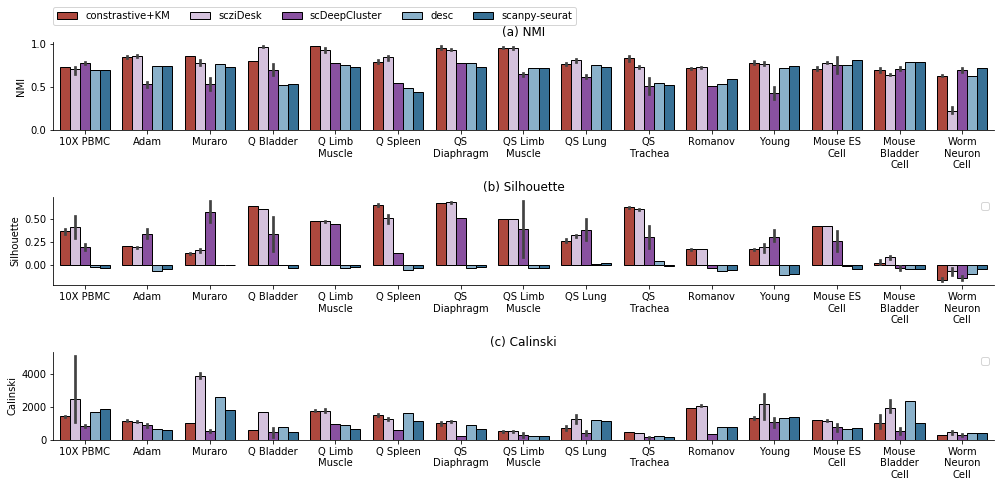

In [28]:
plt.figure(figsize = (14, 7))
ax = plt.subplot(311)
plt.title("(a) NMI")
sns.barplot(x = "dataset_label", y="NMI", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.4), loc=2, borderaxespad=0., ncol = 7)
plt.xlabel("")
sns.despine()

ax = plt.subplot(312)
plt.title("(b) Silhouette")
sns.barplot(x = "dataset_label", y="Silhouette", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()


ax = plt.subplot(313)
plt.title("(c) Calinski")
sns.barplot(x = "dataset_label", y="Calinski", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_NMI_internal_barplot.pdf", bbox_inches='tight')

# Computational time

In [ ]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")
df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"])

df_k = df[[
    'dataset',
    'dropout',
    'kmeans_ari_0',
    'kmeans_nmi_0',
    'run',
    "time",
    'kmeans_pred_0',
]].rename(columns={
    'kmeans_ari_0': "ARI",
    'kmeans_nmi_0': "NMI",
    'kmeans_pred_0': 'pred'
})
df_k["method"] = "constrastive+KM GPU"

df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline_cpu.pkl")
df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"])

df_k_cpu = df[[
    'dataset',
    'dropout',
    'kmeans_ari_0',
    'kmeans_nmi_0',
    'run',
    "time",
    'kmeans_pred_0',
]].rename(columns={
    'kmeans_ari_0': "ARI",
    'kmeans_nmi_0': "NMI",
    'kmeans_pred_0': 'pred'
})
df_k_cpu["method"] = "constrastive+KM CPU"

scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
scDeepCluster["method"] = "scDeepCluster"

sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
sczi["method"] = "scziDesk"

scedar = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scedar.pkl")
scedar["method"] = "scedar"

scanpy = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scanpy.pkl")
scanpy["method"] = "scanpy-seurat"

desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_desc.pkl")
desc["pred"] = desc["pred"].apply(lambda x: x.to_list())
desc["method"] = "desc"


all_data_comp = pd.concat(
    [df_k, df_k_cpu, sczi, scDeepCluster, desc, scanpy])
all_data_comp = all_data_comp.reset_index(drop=True)

ordered_methods = [
     "constrastive+KM CPU",
     "constrastive+KM GPU",
    'scziDesk',
    'scDeepCluster',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scrna',
    'soup',
    'simlr',
    'raceid',
    'cidr',
    'pca_kmeans',
]
ordered_methods = dict(zip(ordered_methods, np.arange(len(ordered_methods))))

all_data_comp["order"] = all_data_comp["method"].apply(lambda x: ordered_methods[x])
sel_methods = ['constrastive+KM', 'scziDesk',  'scDeepCluster','desc','scanpy-seurat']
sel_clrs = [method_color[m] for m in sel_methods]

sel_clrs =[sel_clrs[0]] + sel_clrs

sel_methods = [ "constrastive+KM CPU",  "constrastive+KM GPU", 'scziDesk',  'scDeepCluster','desc','scanpy-seurat']

In [ ]:
g = sns.barplot(x = "method", y="time",
           data = all_data_comp[all_data_comp["method"].isin(sel_methods)].sort_values(by=["order", "dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,)
plt.xticks(rotation = 90)
sns.despine()
plt.ylabel("time/sec")
plt.xlabel("")
g.set_yscale("log")
plt.savefig(f"../diagrams/{category}_computational_time.pdf", bbox_inches='tight')

# Noise analysis

In [ ]:
noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.subplot(121)
sns.boxplot(data = noise, x = "noise", y='kmeans_ari_0', ax = ax)
means = noise.groupby(['noise'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Noise std")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(122)
sns.boxplot(data = noise, x = "noise", y='kmeans_nmi_0', ax = ax)
plt.ylabel("NMI")
means = noise.groupby(['noise'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("Noise std")
sns.despine()
plt.title("(b) NMI")
plt.savefig(f"../diagrams/{category}_noise.pdf", bbox_inches='tight')

# Learning rate

In [ ]:
lr = pd.read_pickle(f"../output/pickle_results/real_data/real_data_lr.pkl")

In [ ]:
plt.figure(figsize = (14, 3))
ax = plt.subplot(121)
sns.boxplot(data = lr, x = "lr", y='kmeans_ari_0', ax = ax)
means = lr.groupby(['lr'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(122)
sns.boxplot(data = lr, x = "lr", y='kmeans_nmi_0', ax = ax)
plt.ylabel("NMI")
means = lr.groupby(['lr'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("Learning rate")
sns.despine()
plt.title("(b) NMI")
plt.savefig(f"../diagrams/{category}_lr.pdf", bbox_inches='tight')

# Nb input genes analysis

In [29]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_genes.pkl")

ordered_genes = ['all','random_half',  500, 1000, 1500, 3000, 5000]

ordered_genes = dict(zip(ordered_genes, np.arange(len(ordered_genes))))

nb_genes["order"] = nb_genes["nb_genes"].apply(lambda x: ordered_genes[x])

def format_label(x, boxplot = False):
    if x == "all":
        if boxplot:
            return "all genes"
        else:
            return "all\ngenes"
    if x == "random_half":
        if boxplot:
            return "random 1/2 genes"
        else:
            return "random 1/2\ngenes"
    else:
        return str(int(x))
nb_genes["nb_genes_boxplot"] = nb_genes["nb_genes"].apply(lambda x:format_label(x, boxplot = True) )
nb_genes["nb_genes"] = nb_genes["nb_genes"].apply(lambda x:format_label(x) )

nb_genes["dataset_label"] = nb_genes["dataset"].apply(
    lambda x: dataset_names.get(x, x))
nb_genes=nb_genes.sort_values(by= "order",  ascending = True)

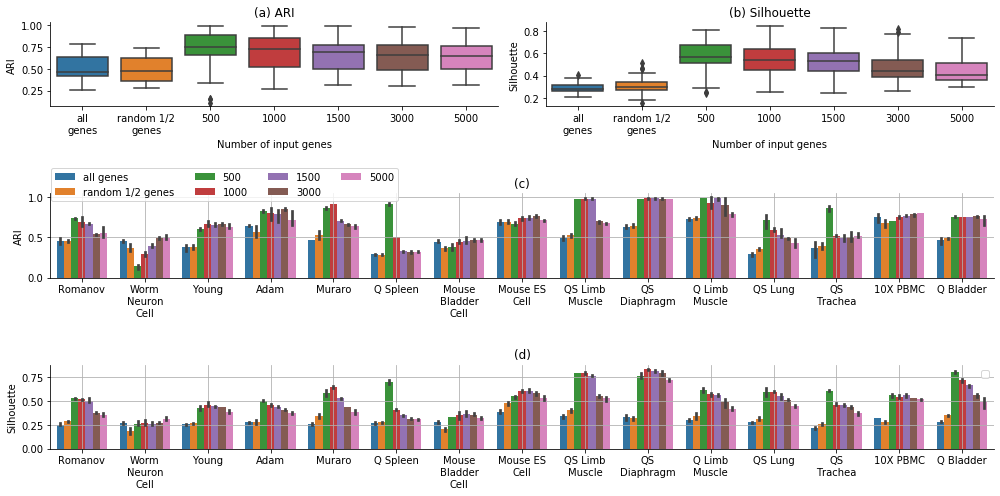

In [42]:
plt.figure(figsize = (14, 7))

ax = plt.subplot(321)
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_ari_0', ax = ax)
plt.ylabel("ARI")
plt.xlabel("Number of input genes")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(322)
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_sil_0', ax = ax)
plt.ylabel("Silhouette")
plt.xlabel("Number of input genes")
sns.despine()
plt.title("(b) Silhouette")


ax = plt.subplot(312)
sns.barplot(data = nb_genes, x = "dataset_label", y = "kmeans_ari_0", hue = "nb_genes_boxplot", ax = ax)
plt.legend(bbox_to_anchor=(0.001, 1.3), loc=2, borderaxespad=0., ncol = 4)
plt.ylabel("ARI")
plt.grid()
plt.title("(c)")
plt.xlabel("")
sns.despine()

ax = plt.subplot(313)
sns.barplot(data = nb_genes, x = "dataset_label", y = "kmeans_sil_0", hue = "nb_genes_boxplot", ax = ax)
plt.legend([])
plt.grid()
plt.ylabel("Silhouette")
plt.title("(d)")
plt.xlabel("")
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_nb_genes.pdf", bbox_inches='tight')

In [ ]:
a = nb_genes[nb_genes["nb_genes"] == '500']["kmeans_ari_0"].values

b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_ari_0"].values

print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

In [ ]:
a = nb_genes[nb_genes["nb_genes"] == '500']["kmeans_nmi_0"].values

b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_nmi_0"].values

print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

# Nb input epochs

In [ ]:
nb_epochs = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_epochs.pkl")
nb_epochs["nb_epochs"] = nb_epochs["nb_epochs"].astype("int")

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.subplot(121)
sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_ari_0', ax = ax)
plt.ylabel("ARI")
plt.xlabel("Number of training epochs")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(122)
sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_nmi_0', ax = ax)
plt.ylabel("NMI")
plt.xlabel("Number of training epochs")
sns.despine()
plt.title("(b) NMI")
plt.savefig(f"../diagrams/{category}_nb_epochs.pdf", bbox_inches='tight')

# Robustness to the number of selected cells

In [ ]:
train_size = pd.read_pickle(f"../output/pickle_results/real_data/real_data_train_size.pkl")


In [ ]:
train_size.groupby(['train_size']).mean()

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.subplot(121)
g = sns.boxplot(data = train_size, x = "train_size", y='kmeans_ari_0', ax = ax)
means = train_size.groupby(['train_size'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(122)
sns.boxplot(data = train_size, x = "train_size", y='kmeans_nmi_0', ax = ax)
means = train_size.groupby(['train_size'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b) NMI")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_train_size.pdf", bbox_inches='tight')

In [ ]:
a = train_size[train_size["train_size"] == 1]["kmeans_ari_0"].values

b = train_size[train_size["train_size"] == 0.6]["kmeans_ari_0"].values

print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

a = train_size[train_size["train_size"] == 1]["leiden_ari_0"].values

b = train_size[train_size["train_size"] == 0.6]["leiden_ari_0"].values

print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

In [ ]:
all_data[all_data["method"] == "scDeepCluster"].groupby("dataset").mean()

# ARI correlation

In [ ]:
df = all_data[['dataset', "method", 'ARI', 'NMI','Silhouette', 'Calinski']]
df.head()

df['Silhouette'] = df['Silhouette'].astype(float)
df['Calinski'] = df['Calinski'].astype(float)

corr = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr is None:
        corr = desc_m
    else:
        corr = pd.concat([corr, desc_m], axis =1)

corr = corr.round(2)

corr = corr[corr.index != "ARI"]

corr = corr[ordered_methods]

corr

In [ ]:
plt.figure(figsize = (12, 2))
ax = plt.gca()
sns.heatmap(corr, annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");
plt.savefig(f"../diagrams/ari_correlation.pdf", bbox_inches='tight')

# Correlation score vs sparsity, etc

In [ ]:
desc = pd.read_excel("../output/pickle_results/real_data/description.xlsx")
desc = desc[['dataset', 'nb_clusters', 'sparsity', 'max_value',
       'non_zero_mean', 'non_zero_median', 'non_zero_skew', 'non_zero_kurosis']]
desc.head()


df = all_data[['dataset', "method", "ARI"]]

desc = pd.merge(desc, df, on = "dataset", how = "right")

corr = None

for method in desc.method.unique():
    desc_m = desc[desc["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr is None:
        corr = desc_m
    else:
        corr = pd.concat([corr, desc_m], axis =1)

corr = corr.round(2)

corr = corr[corr.index != "ARI"].reset_index()

labels = {
    'nb_clusters': "Nb of clusters",
    'sparsity': "Sparsity (ratio of 0 values)",
    'max_value': "Max value",
    'non_zero_mean': "Mean value",
    'non_zero_median': "Median value",
    'non_zero_skew': "Skew",
    'non_zero_kurosis': "Kurtosis"
}
corr["index"] = corr["index"].apply(lambda x: labels[x])
corr = corr.set_index("index", drop = True)
corr = corr[ordered_methods]
corr

In [ ]:
plt.figure(figsize = (12, 5))
ax = plt.gca()
sns.heatmap(corr, annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");
plt.savefig(f"../diagrams/meta_correlation.pdf", bbox_inches='tight')

In [ ]:
sel_methods = ['constrastive+KM', 'constrastive+LD', 'scziDesk', 'scDeepCluster', 'desc', 'scanpy-seurat']

In [ ]:
sel_desc = desc[desc.method.isin(sel_methods)]

In [ ]:
sel_desc = sel_desc.rename(columns = {"nb_clusters": "Nb. of clusters" })

In [ ]:
g = sns.FacetGrid(sel_desc, col="method",  col_wrap=3, height=3, 
                  ylim=(0, 1)
                 )
g.map(sns.regplot, "Nb. of clusters", "ARI")
plt.savefig(f"../diagrams/perf_by_nb_of_clusters.pdf", bbox_inches='tight')

In [ ]:
all_data[all_data["method"] =="scDeepCluster"].groupby("dataset").mean()

# Number of layers

In [ ]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_layers.pkl")
layers.head()

In [ ]:
layers["nb_layers"] = layers["layers"].apply(lambda x: len(x.split(",")))
layers["embedding_size"] = layers["layers"].apply(lambda x: int(x.split(",")[-1].replace("[", '')[:-1]))

In [ ]:
layers9 = layers[layers["dropout"]==0.9]

In [ ]:
r = layers.groupby(["layers", "dropout"
                    ])["kmeans_ari_0"].mean().unstack(["layers"
                                                       ]).T.reset_index()
r["nb_layers"] = r["layers"].apply(lambda x: len(x.split(",")))
r["embedding_size"] = r["layers"].apply(
    lambda x: int(x.split(",")[-1].replace("[", '')[:-1]))
r = r.sort_values(by=["nb_layers", "embedding_size"]).drop(
    ["nb_layers", "embedding_size"], axis=1).reset_index(drop=True).round(3).set_index("layers")

In [ ]:
plt.figure(figsize = (10, 8))
ax = plt.subplot(2,2,1)
sns.boxplot(data =layers9, x = 'nb_layers', y = 'kmeans_ari_0'  , ax = ax)
means = layers9.groupby(['nb_layers'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Number of layers")
sns.despine()
plt.title("(a) Number of layers")


ax = plt.subplot(2,2,3)
sns.boxplot(data =layers9, x = 'embedding_size', y = 'kmeans_ari_0'  , ax = ax)
means = layers9.groupby(['embedding_size'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Representation layer size")
sns.despine()
plt.title("(b) Representation layer size")

ax = plt.subplot(1,2,2)
ax = plt.gca()
sns.heatmap(r, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.title("(c)")
plt.tight_layout()
plt.savefig(f"../diagrams/grid_search.pdf", bbox_inches='tight')

In [ ]:
r.shape

In [ ]:
# plt.figure(figsize = (5, 10))
# ax = plt.gca()
# sns.heatmap(r, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
# plt.ylabel("");
# plt.savefig(f"../diagrams/grid_search.pdf", bbox_inches='tight')

# Dropout level

In [ ]:
dropout = layers[layers["layers"] == "[200, 40, 60]"]

In [ ]:
dropout.groupby("dropout").mean()

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.subplot(121)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_ari_0', ax = ax)
means = dropout.groupby(['dropout'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Gene dropout")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(122)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_nmi_0', ax = ax)
plt.ylabel("NMI")
means = dropout.groupby(['dropout'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.01, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("Gene dropout")
sns.despine()
plt.title("(b) NMI")
plt.savefig(f"../diagrams/{category}_dropout.pdf", bbox_inches='tight')

# Clustering analysis

In [ ]:
all_data["dataset"].unique()

In [ ]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")


In [ ]:
datasets = ['Quake_10x_Limb_Muscle', 'Quake_Smart-seq2_Trachea', 'Quake_10x_Spleen']

In [ ]:
n = len(datasets)
plt.figure(figsize = (14, 4*n))
for i in range(n):
    dataset = datasets[i]
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    cell_names = data_mat['cell_names'][()]

    ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]
    ours

    emb = ours["features_0"].values[0]

    X_embedded = TSNE(n_components=2).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
    X_embedded[dataset] = cell_names

    X_embedded["K Means"] = ours["kmeans_pred_0"].values[0]
    X_embedded["Leiden"] = ours["leiden_pred_0"].values[0]

    X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
    X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
    # plot
    ax = plt.subplot(n, 3, i*3+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari_0"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"K-Means ({n_clust} clusters, ARI {ari})")
    sns.despine()
    
    
    ax = plt.subplot(n, 3, i*3+2)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax,
              )
    ari = round(ours["leiden_ari_0"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"Leiden ({n_clust} clusters, ARI {ari})")
    plt.legend([])
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()

    ax = plt.subplot(n, 3, i*3+3)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue=dataset,
               ax = ax
              )
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=0., ncol = 1)
    plt.title("Ground truth")
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()
    
# plt.tight_layout()

plt.savefig(f"../diagrams/{category}_TSNE_clusters.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (14, 14))
ax = plt.subplot(411)
plt.title("(a)")
sns.barplot(x = "dataset", y="ARI", hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.4), loc=2, borderaxespad=0., ncol = 7)
plt.xlabel("")
sns.despine()

ax = plt.subplot(412)
sns.barplot(x = "dataset", y="ARI", hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.xlabel("")


ax = plt.subplot(413)
plt.title("(b)")
sns.barplot(x = "dataset", y='Calinski', hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()

ax = plt.subplot(414)
sns.barplot(x = "dataset", y='Calinski', hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.tight_layout()
plt.xlabel("")
plt.savefig(f"../diagrams/{category}_ARI_barplot.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (14, 7))
ax = plt.subplot(211)
sns.barplot(x = "dataset", y="NMI", hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.2), loc=2, borderaxespad=0., ncol = 7)
sns.despine()

ax = plt.subplot(212)
sns.barplot(x = "dataset", y="NMI", hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.savefig(f"../diagrams/{category}_NMI_barplot.pdf", bbox_inches='tight')

# Worm dataset analysis

In [ ]:
dataset_names_worm = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES Cell',
    'mouse_ES_cell_select_2100': 'Mouse ES Cell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron Cell (2100)',
    'worm_neuron_cell': 'Worm Neuron Cell',
    'mouse_bladder_cell': 'Mouse Bladder Cell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder  Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
    'Adam': "Adam",
    'Muraro': "Muraro",
    'Romanov': "Romanov",
    'Young': "Young",
}
worm_order =dict(zip(list(dataset_names_worm.keys()), np.arange(len(dataset_names_worm))))
df = pd.read_pickle(
    f"{path}output/pickle_results/real_data/real_data_dataset_tuning.pkl")
df = df.groupby(["dataset",
                 "nb_genes"])[["kmeans_ari_0", "sparsity"
                               ]].mean().unstack("nb_genes").reset_index()
df.columns = ["dataset", "500", "1500", "5000", "sparsity", "s1", "s2"]
df["order"] = df["dataset"].apply(
    lambda x: worm_order.get(x, x))
df = df.sort_values(by = "order")
df["dataset"] = df["dataset"].apply(
    lambda x: dataset_names_worm.get(x, x))

df = df.drop(["s1", "s2", "order"], axis=1).set_index("dataset").round(3)

df

In [ ]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_worm.pkl")
nb_genes["nb_genes"] = nb_genes["nb_genes"].astype(int)

In [ ]:
plt.figure(figsize = (10, 7))
ax = plt.subplot(221)
g = sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_ari_0', ax = ax)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_ari_0"].max() + 0.01
means = nb_genes.groupby(['nb_genes'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(223)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_nmi_0"].max()+ 0.01
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_nmi_0', ax = ax)
means = nb_genes.groupby(['nb_genes'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(b) NMI")
ax = plt.subplot(1,2,2)
sns.heatmap(df, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.title("(c)")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_worm.pdf", bbox_inches='tight')

# Overall Comparaision

In [ ]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(141)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(a) ARI")
plt.xlabel("")
sns.despine()

ax = plt.subplot(142)
sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.xlabel("")
plt.title("(b) NMI")

ax = plt.subplot(143)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(c) Silhouette")
plt.xlabel("")
sns.despine()

ax = plt.subplot(144)
sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(d) Calinski")
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot.pdf", bbox_inches='tight')

In [ ]:
titles = ["(a)", "(b)", "(c)", "(d)"]
plt.figure(figsize = (12, 5))
for i, dropout in enumerate(sorted(all_data.dropout.unique())):
    ax = plt.subplot(2, 2, i+1)
    sns.barplot(x = "nb_clust", y="ARI", 
                data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{titles[i]} dropout rate {dropout} %")
    if i ==1:
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    else: 
        plt.legend([],[], frameon=False)
    if i in [2, 3]:
        plt.xlabel("Nb. of clusters")
    else:
        plt.xlabel("")
    sns.despine()
# plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize=(14, 12))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["balanced data", "imbalanced data", "real data"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):
    all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
    
    ax = plt.subplot(3,4,i*4 +1)
    sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4]} ARI {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +2)
    sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.xlabel("")
    plt.title(f"{letters[i*4 +1]} NMI {titles[i]}")

    ax = plt.subplot(3,4,i*4 +3)
    sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +2]} Silhouette {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +4)
    sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +3]}  Calinski {titles[i]}")
    plt.xlabel("")
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_barplot.pdf", bbox_inches='tight')

In [ ]:
df.groupby("dataset").mean()

# Importance of input size

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_genes", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    for run in range(2):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        for nb_genes in [100, 200, 500, 1000, 1500, 2000, 5000, 8000]:

            X = np.array(data_mat['X'])
            Y = np.array(data_mat['Y'])
            perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
            print(f"Perc 0 {perc_0}")
            cluster_number = np.unique(Y).shape[0]

            X = train.preprocess(X, nb_genes=nb_genes)
            nb_zeros = int(0.8 * nb_genes)
            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=100,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/inputs/{dataset}_{nb_genes}/")

            #         df.loc[df.shape[0]] = [
            #                 dataset, perc_0, nb_genes, 'kmeans_representation_0',dresults['kmeans_representation_0']
            #             ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'leiden_representation_0',
                dresults['leiden_representation_0'], run]

#             pxt = PCA(2).fit_transform(X)
#             dresults["original"] = utils.evaluate(X, Y, cluster_number)[1]
#             dresults["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
            print(dresults)
    df.to_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df.groupby(["nb_genes"]).mean()

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_genes": "Nb input genes"})

In [ ]:
df["dataset"].unique()


In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size.pdf", bbox_inches='tight')

In [ ]:
datasets = ['10X PBMC (2100)',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Mouse Bladder\n Cell (2100)']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size_2100.pdf", bbox_inches='tight')

# Importance of the number of epochs

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_epochs", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    nb_genes = 1500
    for epochs in [5, 50, 100, 300]:

        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
        print(f"Perc 0 {perc_0}")
        cluster_number = np.unique(Y).shape[0]

        X = train.preprocess(X, nb_genes=nb_genes)
        nb_zeros = int(0.8 * nb_genes)
        for run in range(2):
            torch.manual_seed(run)
            torch.cuda.manual_seed_all(run)
            np.random.seed(run)
            random.seed(run)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=epochs,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/epochs/{dataset}_{epochs}/")

            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'kmeans_representation_0',
                dresults['kmeans_representation_0'], run
            ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'leiden_representation_0',
                dresults['leiden_representation_0'], run
            ]

            print(dresults)
            df.to_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_epochs": "Nb epochs"})

In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(7, 3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb epochs",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title ="Number of epochs",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_nb_epochs.pdf", bbox_inches='tight')

In [44]:
# category = "imbalanced_data"
category = "balanced_data"
# category = "real_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

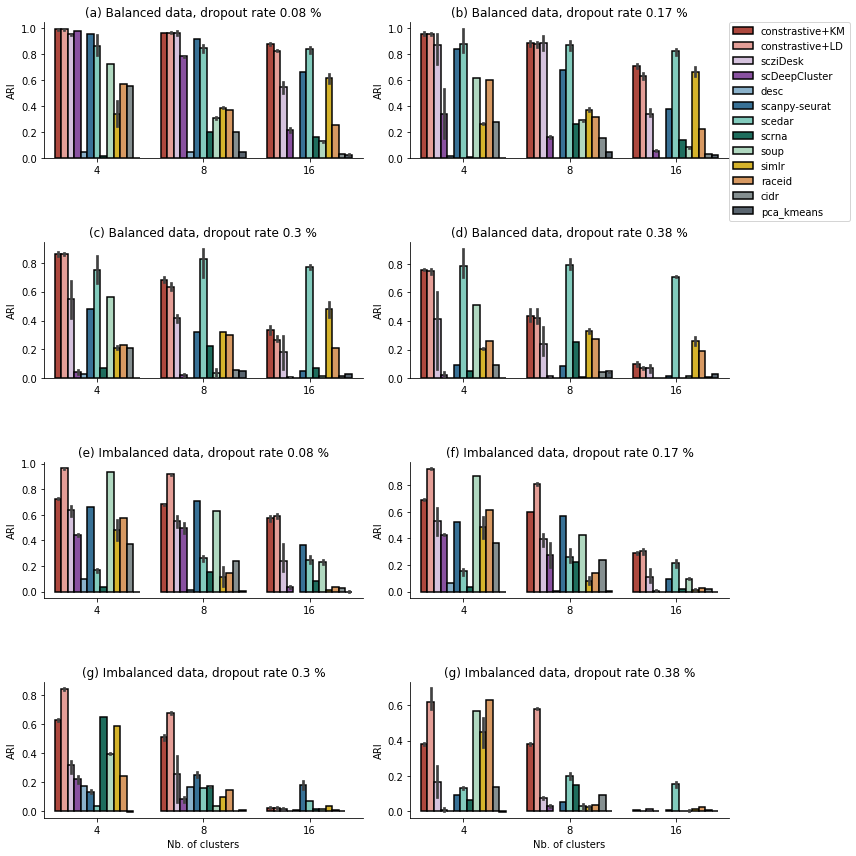